 # Modelling tests neural network



### Table of Contents

* [datasets](#datasets)
    * [creation de la base](#dataset)
* [SVM sur features](#svm_features)
    * [base sous echantillonée](#svm_features_sous)
        * [test](#svm_features_sous_test)
        * [gridsearch](#svm_features_sous_grid)
     * [base sur echantillonée](#svm_features_sur)
 * [Resultats](#svm_features_sur_res)


je teste ici des modèles de réseaux de neurones d'abord sur les signaux brutes
je ne détaille pas toutes les expériences faites.

Sur une base suréchantillonée de 13000 signaux par classe, les modèles ANN ne marchent pas très bien.
il y a trop de signaux normaux classés en anormaux.

De plus, il y a un décallage avec le train et le test. la loss sur le train continue de descendre alors que sur le test, on arrive à un plateau.
Il n'y a pas besoins de faire énormément d'itération pour arriver à ce plateau.
A partir de la le modèle s'overfit.

Par conséquent j'ai esssayé d'abord d'augementer la base avec 60000 signaux par classe et cela améliore nettement les résultats


j'ai testé plusieeurs types de modèles constituées de couches de réseaux de neurones. avec des hidden layers de mêmes nombre de neurones ou des hidden layers avec un nombre de neurones divisé par 2 à chaque couches. je fais aussi varier l'activation.

In [1]:
import os
import sys
sys.path.append('../src')
import time

from balance import load_balanced
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score

import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
from torch import optim

## modèles

In [2]:

def modele_type_1(n,activation=nn.Sigmoid,input_shape=187,device='cpu'):
    model = nn.Sequential(
       nn.Linear(input_shape, n),
       activation(),
       nn.Linear(n, n),
       activation(),
       nn.Linear(n, n // 2),
       activation(),  
       nn.Linear(n // 2, 5)
    )
    model.to(device)
    summary(model, input_size=(input_shape,), device=device)
    return model
def modele_type_2(n,activation=nn.Sigmoid,input_shape=187,device='cpu'):
    model = nn.Sequential(
       nn.Linear(input_shape, n),
       activation(),
       nn.Linear(n, n),
       activation(),
       nn.Linear(n, n),
       activation(),
       nn.Linear(n , 5)
    )   
    model.to(device)
    summary(model, input_size=(input_shape,), device=device)
    return model

def modele_type_3(n,p,activation=nn.Sigmoid,input_shape=187,device='cpu'):
    model = nn.Sequential()
    model.add_module("dense_start", nn.Linear(input_shape, n))
    model.add_module("act_start", activation())

    for couche in range(p):
        model.add_module("dense%d" %couche, nn.Linear(n, n))
        model.add_module("act%d" %couche, activation())
    model.add_module("dense_end", nn.Linear(n, 5))
    #model.add_module("act_start", nn.Sigmoid())
    model.to(device)
    summary(model, input_size=(input_shape,), device=device)
    return model


## fonction d'entrainement et de test

j'utilise volontairement la précision 'macro' puisque la base de test est elle aussi totalement déséquilibrée. je voudrais que les anormaux ne soient pas classé en classe normal. 

si l'on prend la précision classique, j'ai des valeurs qui dépassent 90% alors que plus de la moitié des classe 1 est classée en 0
il faudra envisagé une sortie de l'entrainement si cette précision macro atteint une certaine valeur.

la précision marco du coup va minimiser l'impact d'avoir bien classé un grand nmbre de classe 0

il faudrait faire une base de cross - validation

In [22]:
def evaluate_model(model, test_set):
    X, y_true = test_set[:]
   
    model.eval()
    criterion = nn.CrossEntropyLoss()
    # Calcul de la fonction de perte
    
    with torch.no_grad():
        # Prédiction du modèle pour un batch donné
        y_pred = model(X)

    loss_test = criterion(y_pred, y_true)
    
    y_pred = np.argmax(y_pred.detach().numpy(),axis=1)
    y_true = y_true.numpy()
    accuracy = precision_score(y_true, y_pred,average='macro')
    recall = recall_score(y_true, y_pred,average='macro')
    return y_true, y_pred, accuracy, recall, loss_test.item()
    
def train_a_model(model,train_loader,test_set,epochs = 100,lr=1e-3,device='cpu'):

    
    optimizer = optim.Adam(model.parameters(), lr)

    # Définition de la fonction de perte
    criterion = nn.CrossEntropyLoss()

    loss_list = []
    loss_list_test = []

    accuracy_list = []
    start = time.time()
    
    for epoch in range(epochs):
        # Dans ce mode certaines couches du modèle agissent différemment
        model.train()
        loss_total = 0
        
        for batch in train_loader:
            # Batch de données
            X_batch, y_batch = batch
            
            # Device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Gradient mis 0
            model.zero_grad()
    
            # Calcul de prédiction
            y_pred = model(X_batch)
    
            # Calcul de la fonction de perte
            loss = criterion(y_pred, y_batch)
    
            # Backpropagation : calculer le gradient de la loss en fonction de chaque couche
            loss.backward()
            
            # Clipper le gradient entre 0 et 1 pour plus de stabilité
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Descente de gradient : actualisation des paramètres
            optimizer.step()
            
            loss_total += loss.item()

        y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
        
        loss_list.append(loss_total/len(train_loader))
        loss_list_test.append(loss)
        accuracy_list.append(accuracy)
        print(f"Epoch : {epoch+1}/{epochs} -- Training loss {loss_total/len(train_loader)}, --- Val loss {loss}, --- accuray : {accuracy}, --- recall : {recall}")
    
    print("hello")
    end = time.time()
    
    print("execution time: ",end - start)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(loss_list,label='loss train')
    ax.plot(loss_list_test,label='loss test')
    ax.legend()

    table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
    print(table)

    print(classification_report(y_true, y_pred))

## base de données à 13000 signaux par classe

### creation de la base <a class="anchor" id="dataset"></a>

base sur echantillonée: N signaux par classe=13000

In [26]:
if not os.path.isfile('../data/processed/mitbih_train_smote_perturb_13000.csv'):
    Xo,yo = load_balanced.load_balanced_data(method='smote-perturb',n_normal=13000,
                       smote_perturb_smote_ratio=0.5)
    pd.DataFrame(np.concatenate((Xo,np.expand_dims(yo,axis=1)),axis=1)).to_csv('../data/processed/mitbih_train_smote_perturb_13000.csv',index=None,header=None)

calcul des features sur ces bases

In [29]:

if not os.path.isfile('../data/processed/features_mitbih_train_smote_perturb_13000.csv'):
    from features import build_features
    build_features.transform_inputs(files=['../data/processed/mitbih_train_smote_perturb_13000.csv'],
                     outdir = '../data/processed',
                    applyfilter='gaussian',
                      paramfilter=1,
                      Fs=125,
                      nech=6)


### chargement si précalculée

In [4]:
X_train, y_train = load_balanced.load('../data/processed/mitbih_train_smote_perturb_13000.csv')
X_test, y_test = load_balanced.load('../data/raw/mitbih_test.csv')

train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.Tensor(torch.from_numpy(y_train).long()))
test_set = TensorDataset(torch.from_numpy(X_test).float(), torch.Tensor(torch.from_numpy(y_test).long()))

train_loader = DataLoader(train_set, batch_size=30, shuffle=True)

### modèle type 1 example: couches de 64 puis 32 puis 16 neurones

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            12,032
├─Sigmoid: 1-2                           --
├─Linear: 1-3                            4,160
├─Sigmoid: 1-4                           --
├─Linear: 1-5                            2,080
├─Sigmoid: 1-6                           --
├─Linear: 1-7                            165
Total params: 18,437
Trainable params: 18,437
Non-trainable params: 0
Epoch : 1/50 -- Training loss 0.899216373848596, --- Val loss 0.9214242696762085, --- accuray : 0.47048379619820224, --- recall : 0.7577590367162989
Epoch : 2/50 -- Training loss 0.59314448634325, --- Val loss 0.9031767845153809, --- accuray : 0.45689610315443874, --- recall : 0.7871058280454533
Epoch : 3/50 -- Training loss 0.5072883933981993, --- Val loss 0.7436217665672302, --- accuray : 0.4864449684646031, --- recall : 0.8104575285010854
Epoch : 4/50 -- Training loss 0.4434171589525493, --- Val loss 0.6296801567077637, --- accuray : 0.515248833215489, 

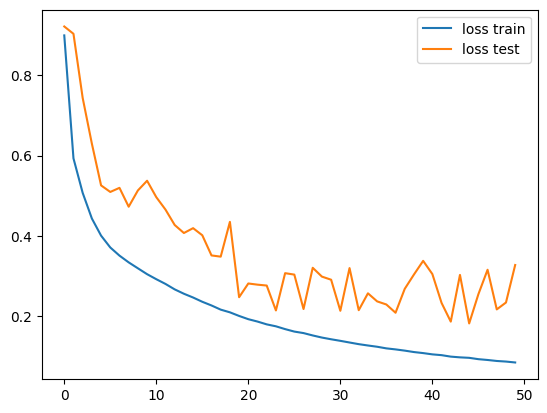

In [5]:
model = modele_type_1(64)
train_a_model(model,train_loader,test_set,epochs = 50,lr=1e-3)

trop de classes 0 sont prédits en 1 2, 3 ,4. une piste d'amélioration pour ce modèle est d'aller voir ces signaux. sinon le reste ca va
ce qui en soit se traduit par envoyer des non malades faire de plus amples examens donc cela n'est pas si grave.

### modèle type 2 example: couches de 64 puis 64 puis 64 neurones

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            12,032
├─ReLU: 1-2                              --
├─Linear: 1-3                            4,160
├─ReLU: 1-4                              --
├─Linear: 1-5                            4,160
├─ReLU: 1-6                              --
├─Linear: 1-7                            325
Total params: 20,677
Trainable params: 20,677
Non-trainable params: 0
Epoch : 1/50 -- Training loss 0.5499549873437978, --- Val loss 0.5743710994720459, --- accuray : 0.5417820906460391, --- recall : 0.8462415687170068
Epoch : 2/50 -- Training loss 0.33488118419029167, --- Val loss 0.3671984076499939, --- accuray : 0.5930765991459507, --- recall : 0.8672536726288923
Epoch : 3/50 -- Training loss 0.2678754298643041, --- Val loss 0.545330286026001, --- accuray : 0.5670576366863663, --- recall : 0.8827325500752561
Epoch : 4/50 -- Training loss 0.22814039502595432, --- Val loss 0.3062397837638855, --- accuray : 0.630782279420425

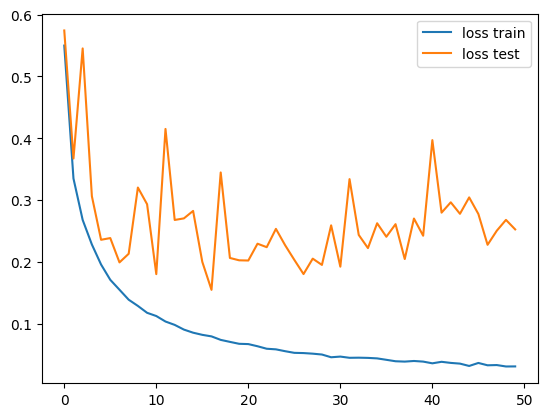

In [6]:
model = modele_type_2(64,activation=nn.ReLU)
train_a_model(model,train_loader,test_set,epochs = 50,lr=1e-3)

la même chose 

### modèle type 3 example: 5 couches cachées de 32 neurones

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            12,032
├─Sigmoid: 1-2                           --
├─Linear: 1-3                            4,160
├─Sigmoid: 1-4                           --
├─Linear: 1-5                            4,160
├─Sigmoid: 1-6                           --
├─Linear: 1-7                            4,160
├─Sigmoid: 1-8                           --
├─Linear: 1-9                            4,160
├─Sigmoid: 1-10                          --
├─Linear: 1-11                           4,160
├─Sigmoid: 1-12                          --
├─Linear: 1-13                           325
Total params: 33,157
Trainable params: 33,157
Non-trainable params: 0
Epoch : 1/40 -- Training loss 1.0325922747883975, --- Val loss 1.1797202825546265, --- accuray : 0.43771921494545635, --- recall : 0.6890555613015368
Epoch : 2/40 -- Training loss 0.7640313941402593, --- Val loss 1.0349620580673218, --- accuray : 0.4804699632137339, --- recall : 0.7216775

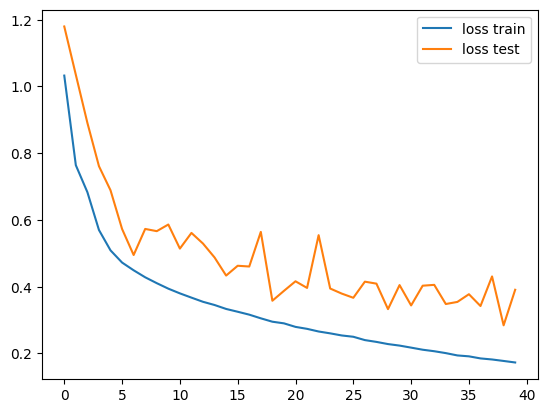

In [7]:
model = modele_type_3(64,5,activation=nn.Sigmoid)
train_a_model(model,train_loader,test_set,epochs = 40,lr=1e-3)

### conclusion

les modèles ont du mal a classer les anormaux.il faudrait soit ajouter du dropout soit augmenter le dataset.

régularisation c'est possible?

## base de données à 50000 signaux par classe

In [8]:
#X_train,y_train = load_balanced.load_balanced_data(method='smote-perturb',n_normal=50000,smote_perturb_smote_ratio=0.5)
#pd.DataFrame(np.concatenate((X_train,np.expand_dims(y_train,axis=1)),axis=1)).to_csv('../data/processed/mitbih_train_smote_perturb_50000.csv',index=None,header=None)

X_train, y_train = load_balanced.load('../data/processed/mitbih_train_smote_perturb_50000.csv')

In [9]:
train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.Tensor(torch.from_numpy(y_train).long()))
train_loader = DataLoader(train_set, batch_size=30, shuffle=True)

In [10]:
pd.Series(y_train).value_counts()

0.0    50000
1.0    50000
2.0    50000
3.0    50000
4.0    50000
Name: count, dtype: int64

### modele 2

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            12,032
├─ReLU: 1-2                              --
├─Linear: 1-3                            4,160
├─ReLU: 1-4                              --
├─Linear: 1-5                            4,160
├─ReLU: 1-6                              --
├─Linear: 1-7                            325
Total params: 20,677
Trainable params: 20,677
Non-trainable params: 0
Epoch : 1/30 -- Training loss 0.34273918147661725, --- Val loss 0.25930193066596985, --- accuray : 0.6758243551268968, --- recall : 0.8979047729474867
Epoch : 2/30 -- Training loss 0.1720964315965126, --- Val loss 0.1521950215101242, --- accuray : 0.7503140725936529, --- recall : 0.8959805603105829
Epoch : 3/30 -- Training loss 0.12393590374401062, --- Val loss 0.20442655682563782, --- accuray : 0.6850825421163982, --- recall : 0.903200251064162
Epoch : 4/30 -- Training loss 0.09985138403387488, --- Val loss 0.21844862401485443, --- accuray : 0.69034270277

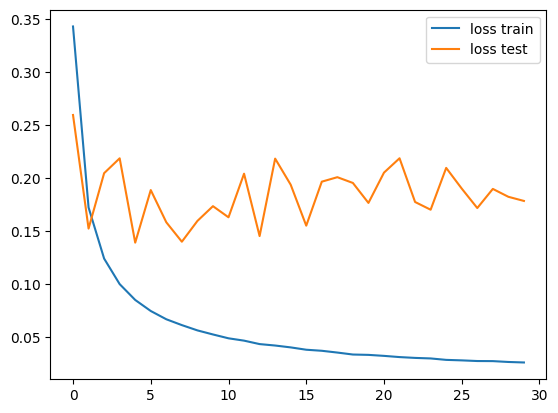

In [11]:
model = modele_type_2(64,activation=nn.ReLU)
train_a_model(model,train_loader,test_set,epochs = 30,lr=1e-3)

bonne amélioration

## modele 1

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            24,064
├─Sigmoid: 1-2                           --
├─Linear: 1-3                            16,512
├─Sigmoid: 1-4                           --
├─Linear: 1-5                            8,256
├─Sigmoid: 1-6                           --
├─Linear: 1-7                            325
Total params: 49,157
Trainable params: 49,157
Non-trainable params: 0
Epoch : 1/30 -- Training loss 0.5772413490753587, --- Val loss 0.44823572039604187, --- accuray : 0.583014240012617, --- recall : 0.8449888669717683
Epoch : 2/30 -- Training loss 0.34156697662469004, --- Val loss 0.5378205180168152, --- accuray : 0.5708597292827327, --- recall : 0.8763306201339459
Epoch : 3/30 -- Training loss 0.26300343837770507, --- Val loss 0.25066429376602173, --- accuray : 0.6766464718287436, --- recall : 0.8827461598899324
Epoch : 4/30 -- Training loss 0.2065639803406206, --- Val loss 0.363812655210495, --- accuray : 0.6211331471708

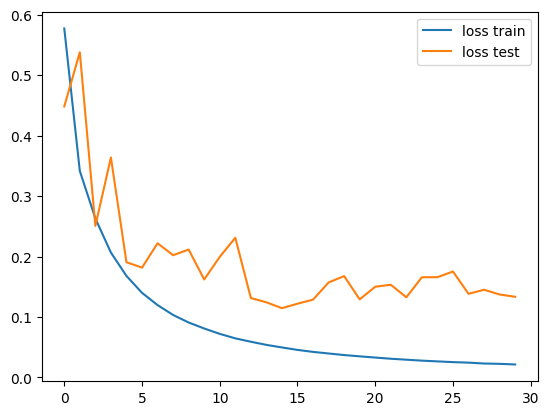

In [12]:
model = modele_type_1(128,activation=nn.Sigmoid)
train_a_model(model,train_loader,test_set,epochs = 30,lr=1e-3)


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            24,064
├─ReLU: 1-2                              --
├─Linear: 1-3                            16,512
├─ReLU: 1-4                              --
├─Linear: 1-5                            8,256
├─ReLU: 1-6                              --
├─Linear: 1-7                            325
Total params: 49,157
Trainable params: 49,157
Non-trainable params: 0
Epoch : 1/30 -- Training loss 0.2922409872673291, --- Val loss 0.3157089352607727, --- accuray : 0.6207794088265176, --- recall : 0.8960822805869659
Epoch : 2/30 -- Training loss 0.13119279975681702, --- Val loss 0.20398709177970886, --- accuray : 0.7017813824732746, --- recall : 0.9174470771404956
Epoch : 3/30 -- Training loss 0.09381705538322235, --- Val loss 0.16995054483413696, --- accuray : 0.7195155950373723, --- recall : 0.9164077081237041
Epoch : 4/30 -- Training loss 0.07493966074582978, --- Val loss 0.18347537517547607, --- accuray : 0.730049122

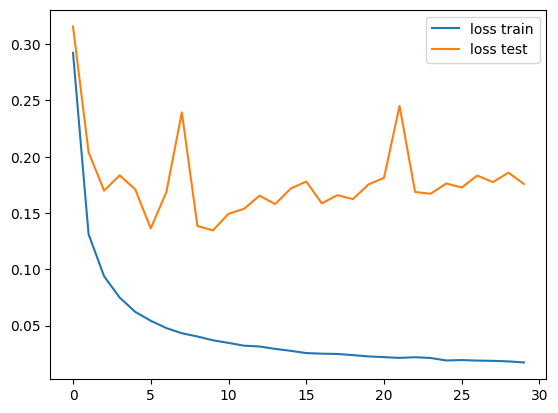

In [14]:
model = modele_type_1(128,activation=nn.ReLU)
train_a_model(model,train_loader,test_set,epochs = 30,lr=1e-3)


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            24,064
├─LeakyReLU: 1-2                         --
├─Linear: 1-3                            16,512
├─LeakyReLU: 1-4                         --
├─Linear: 1-5                            8,256
├─LeakyReLU: 1-6                         --
├─Linear: 1-7                            325
Total params: 49,157
Trainable params: 49,157
Non-trainable params: 0
Epoch : 1/30 -- Training loss 0.27383489870066896, --- Val loss 0.171176478266716, --- accuray : 0.7589396944204186, --- recall : 0.8981254000959893
Epoch : 2/30 -- Training loss 0.11963442552985389, --- Val loss 0.24843449890613556, --- accuray : 0.6945047371893462, --- recall : 0.9186812919793244
Epoch : 3/30 -- Training loss 0.08648384475577538, --- Val loss 0.16279512643814087, --- accuray : 0.7302726666983139, --- recall : 0.9111040977007632
Epoch : 4/30 -- Training loss 0.069357310175182, --- Val loss 0.14893046021461487, --- accuray : 0.77743403677

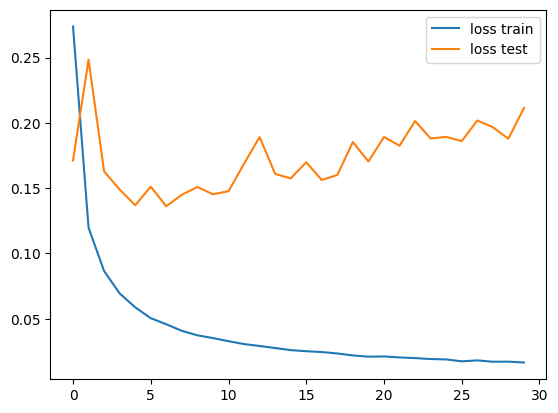

In [15]:
model = modele_type_1(128,activation=nn.LeakyReLU)
train_a_model(model,train_loader,test_set,epochs = 30,lr=1e-3)

test

In [29]:
 model = nn.Sequential(
       nn.Linear(187, 50),
       nn.Sigmoid(),
       nn.Linear(50, 10),
       nn.LeakyReLU(),
       nn.Linear(10 , 5)
    )   
model.to("cpu")


Sequential(
  (0): Linear(in_features=187, out_features=50, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=50, out_features=10, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=10, out_features=5, bias=True)
)

Epoch : 1/100 -- Training loss 0.5726224952374026, --- Val loss 0.5340905785560608, --- accuray : 0.5417080495934685, --- recall : 0.8465498130415086
Epoch : 2/100 -- Training loss 0.35985621141919294, --- Val loss 0.5736247301101685, --- accuray : 0.5382250648682667, --- recall : 0.8692067700986004
Epoch : 3/100 -- Training loss 0.2990355551605345, --- Val loss 0.6381044983863831, --- accuray : 0.5073624187553099, --- recall : 0.8727651259848106
Epoch : 4/100 -- Training loss 0.25428911702175927, --- Val loss 0.41571545600891113, --- accuray : 0.5825218913391349, --- recall : 0.8796389393557356
Epoch : 5/100 -- Training loss 0.22078487570731686, --- Val loss 0.3152118921279907, --- accuray : 0.6282396599394799, --- recall : 0.8974555629304957
Epoch : 6/100 -- Training loss 0.19755096991645016, --- Val loss 0.356494277715683, --- accuray : 0.6031807453406361, --- recall : 0.9043367154800211
Epoch : 7/100 -- Training loss 0.18047503846466634, --- Val loss 0.30837854743003845, --- accura

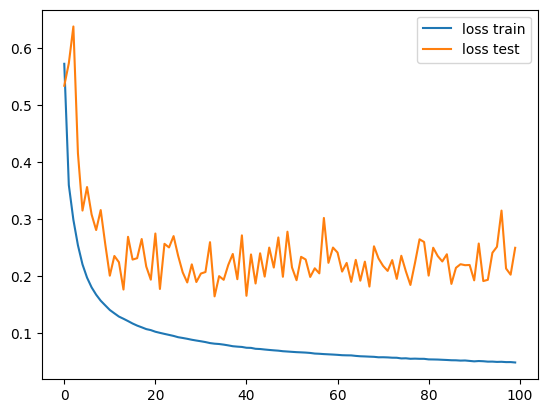

In [30]:
train_a_model(model,train_loader,test_set,epochs = 100,lr=1e-3)

In [23]:
y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)

table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])

In [24]:
N_sains = table.loc[0,:].sum()
N_malades = table.sum().sum() - N_sains
print('total sains:'  ,N_sains)
print('total Malades:'  ,N_malades)
N_malades_non_detectes = table[0].iloc[1::].sum()

N_sains_mais_dits_malades = table.loc[0].iloc[1::].sum()
print('malades non détectés:' , N_malades_non_detectes , '(%.1f' % ( N_malades_non_detectes/N_malades*100) ,'%)')
print('sains envoyés en examen:' , N_sains_mais_dits_malades , '(%.1f' % (N_sains_mais_dits_malades/N_sains*100) ,'%)')

total sains: 18118
total Malades: 3774
malades non détectés: 145 (3.8 %)
sains envoyés en examen: 745 (4.1 %)


## DNN sur features <a class="anchor" id="svm_features"></a>

### base sous echantillonée <a class="anchor" id="svm_features_sous"></a>

### Base sur echantillonée<a class="anchor" id="svm_features_sur"></a>


In [7]:
df = pd.read_csv('../data/processed/features_mitbih_train_smote_perturb_13000.csv')
df.head()
y_train = df.pop('target')
X_train = df
df = pd.read_csv('../data/processed/features_mitbih_test.csv')
y_test = df.pop('target')
X_test = df

In [8]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled  = scaler.transform(X_train )
X_test_scaled  = scaler.transform(X_test )

In [10]:
train_set = TensorDataset(torch.from_numpy(X_train_scaled).float(), nn.functional.one_hot(torch.Tensor(torch.from_numpy(y_train.values).long())).float())
test_set = TensorDataset(torch.from_numpy(X_test_scaled).float(), nn.functional.one_hot(torch.Tensor(torch.from_numpy(y_test.values).long())).float())

train_set = TensorDataset(torch.from_numpy(X_train_scaled).float(), torch.Tensor(torch.from_numpy(y_train.values).long()))
test_set = TensorDataset(torch.from_numpy(X_test_scaled).float(), torch.Tensor(torch.from_numpy(y_test.values).long()))

train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
train_loader = DataLoader(train_set, batch_size=100, shuffle=True)

In [78]:
model = nn.Sequential(
   nn.Linear(X_train.shape[1], 10),
   nn.ReLU(),
   nn.Linear(10, 8),
   nn.ReLU(),
   nn.Linear(8, 5)
)
model.to(device)

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            6,016
├─ReLU: 1-2                              --
├─Linear: 1-3                            1,056
├─ReLU: 1-4                              --
├─Linear: 1-5                            528
├─ReLU: 1-6                              --
├─Linear: 1-7                            85
Total params: 7,685
Trainable params: 7,685
Non-trainable params: 0
